tgb - 8/13/2019 - Drafting the figures for the manuscript

# 0) Initialization

In [1]:
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit
import matplotlib as mpl

Using the 506x506 simulation for consistency with David's work

In [2]:
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/output/'

In [3]:
RCE300 = xr.open_mfdataset(path+'lfff????????.nc')

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [4]:
RCE300.TQV

<xarray.DataArray 'TQV' (time: 2400, rlat: 506, rlon: 506)>
dask.array<shape=(2400, 506, 506), dtype=float32, chunksize=(1, 506, 506)>
Coordinates:
  * rlon        (rlon) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * rlat        (rlat) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
    lon         (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 15.149995
    lat         (rlat, rlon) float32 -2.504478e-06 -2.5044778e-06 ... 15.149999
    height_2m   float32 2.0
    height_toa  float32 33250.0
  * time        (time) datetime64[ns] 2011-07-12T12:00:00 ... 2011-10-20T11:00:00
Attributes:
    standard_name:  atmosphere_water_vapor_content
    long_name:      precipitable water
    units:          kg m-2
    grid_mapping:   rotated_pole

In [5]:
dt = 3600; # Timestep in seconds
tcoor = dt*np.arange(0,RCE300.time.shape[0])

In [6]:
t_range = np.arange(0,np.size(RCE300.time)-2)
dMSE_dt = (RCE300.FMSE.values[t_range+2,:,:]-RCE300.FMSE.values[t_range,:,:])/(2*dt)
dMSE_dt = np.concatenate((dMSE_dt[0:1,:,:],dMSE_dt,np.tile(dMSE_dt[-1,:,:],(1,1,1))),axis=0)

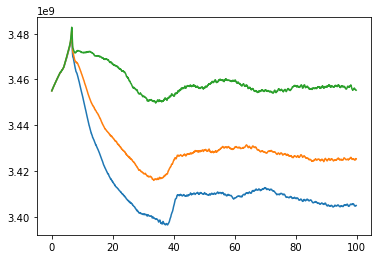

In [7]:
it = np.arange(0,2397)

plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=25,axis=(1,2)))
plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=50,axis=(1,2)))
plt.plot(tcoor[it]/(24*3600),np.percentile(a=RCE300.FMSE[it,:,:],q=75,axis=(1,2)))

# 1) Figure 1a = PDF CWV at different times

Chose days based on spinup, coalescence and coarsening phases and RGB codes defined by Dave

In [8]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

SPINrgb = np.array([255,126,14])/255
COALrgb = np.array([43,160,43])/255
COARrgb = np.array([31,119,179])/255

In [9]:
CWV_PDF_SPIN,SPINedges = np.histogram(RCE300.TQV[:(24*COALstart),:,:],bins=100,density=True)
CWV_PDF_COAL,COALedges = np.histogram(RCE300.TQV[(24*COALstart):(24*COARstart),:,:],bins=100,density=True)
CWV_PDF_COAR,COARedges = np.histogram(RCE300.TQV[(24*ENDstart):,:,:],bins=100,density=True)

In [10]:
# Bin daily to put uncertainty bounds on PDF
# Spinup phase
day = SPINstart
for i in range(11):
    print('i=',i,' & day=',day,'              ',end='\r')
    PDFtmp,tmp = np.histogram(RCE300.TQV[(24*day):(24*(day+1)),:,:],bins=SPINedges,density=True)
    day += 1
    if i==0: SPIN_min = PDFtmp; SPIN_max = PDFtmp;
    else: SPIN_min = np.minimum(SPIN_min,PDFtmp); SPIN_max = np.maximum(SPIN_max,PDFtmp)
# Coalescence phase
day = COALstart
for i in range(14):
    print('i=',i,' & day=',day,'              ',end='\r')
    PDFtmp,tmp = np.histogram(RCE300.TQV[(24*day):(24*(day+1)),:,:],bins=COALedges,density=True)
    day += 1
    if i==0: COAL_min = PDFtmp; COAL_max = PDFtmp;
    else: COAL_min = np.minimum(COAL_min,PDFtmp); COAL_max = np.maximum(COAL_max,PDFtmp)
# Coarsening phase
day = ENDstart
for i in range(15):
    print('i=',i,' & day=',day,'              ',end='\r')
    PDFtmp,tmp = np.histogram(RCE300.TQV[(24*day):np.minimum(2397,(24*(day+1))),:,:],bins=COARedges,density=True)
    day += 1
    if i==0: COAR_min = PDFtmp; COAR_max = PDFtmp;
    else: COAR_min = np.minimum(COAR_min,PDFtmp); COAR_max = np.maximum(COAR_max,PDFtmp)

In [11]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [12]:
fz = 15
lw = 3

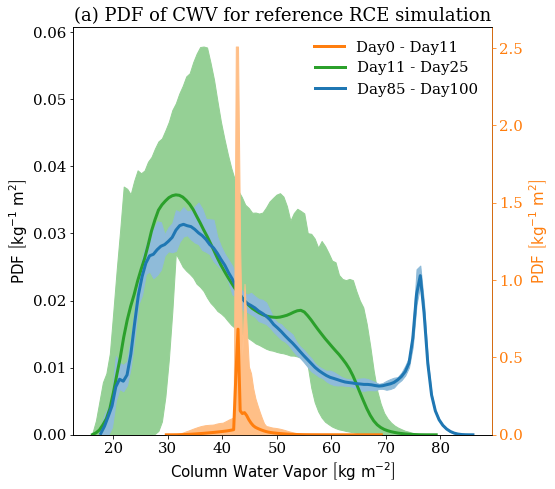

In [15]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(figsize=(7.5,7.5))
ax2 = ax.twinx()

# Shading goes in the back
ax2.fill_between(edgTObin(SPINedges),SPIN_min,SPIN_max,color=1-(1-SPINrgb)/2)
ax.fill_between(edgTObin(COALedges),COAL_min,COAL_max,color=1-(1-COALrgb)/2)
ax.fill_between(edgTObin(COARedges),COAR_min,COAR_max,color=1-(1-COARrgb)/2)

# Right axis = Day 11-100
SPINline = ax2.plot(edgTObin(SPINedges),CWV_PDF_SPIN,color=SPINrgb,label='Day0 - Day11')

ax2.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$',color=SPINrgb)
ax2.spines['right'].set_color(SPINrgb)
ax2.tick_params(axis='y', colors=SPINrgb)
ax2.set_ylim((0,ax2.get_ylim()[1]))
leg2 = ax2.legend(frameon=False,bbox_to_anchor=(0,0,0.95,1))

# Left axis = Day0-Day11
COALline = ax.plot(edgTObin(COALedges),CWV_PDF_COAL,color=COALrgb,label='Day11 - Day25')

COARline = ax.plot(edgTObin(COARedges),CWV_PDF_COAR,color=COARrgb,label='Day85 - Day100')

leg = ax.legend(frameon=False,bbox_to_anchor=(0,0,1,0.95))
ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$')
ax.set_ylim((0,ax.get_ylim()[1]))
ax.set_title('(a) PDF of CWV for reference RCE simulation')

plt.draw()

In [17]:
# Save figure
path_home = '/users/tbeucler/'
plt.savefig(path_home+'Fig1a',format='pdf')

<Figure size 432x288 with 0 Axes>

# 2) Figure 2a/c = Potential, Landau, Contour

Define value of zero potential; use median value of last week of FMSE.

In [26]:
bin0=np.percentile(a=RCE300.FMSE[-24*7:,:,:],q=50,axis=(0,1,2))

Use the bin edges of the coarsened PDF to calculate the potential and Landau free energy

In [28]:
F,binm,V = Landau.Landau_energy(RCE300.FMSE,dMSE_dt,bin0,N_bins=30)

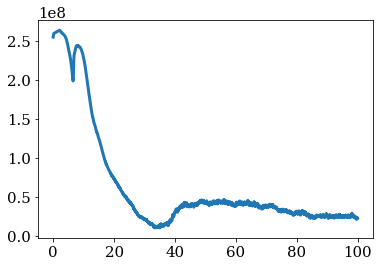

In [30]:
plt.plot(tcoor/(24*3600),F)

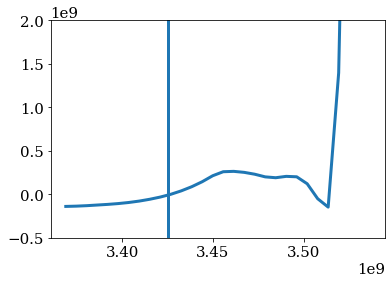

In [34]:
plt.plot(binm,V)
plt.ylim((-5e8,2e9))
plt.axvline(x=bin0)

Calculate PDF using 100 bins

In [36]:
MSE_PDF,PDFedges = np.histogram(RCE300.FMSE,bins=100,density=True)

Calculate evolution of contour over full time period

In [39]:
dx = 3.3e3
CL = np.zeros((np.size(tcoor),))

for it,t in enumerate(tcoor):
    print('it=',it,'           ',end='\r')
    Contour = curve.get_contours(RCE300.FMSE[it,:,:]>\
                                 np.median(RCE300.FMSE[it,:,:],axis=(0,1))[np.newaxis,np.newaxis],
                                 minLength=0)
    L = 0
    for i,contour in enumerate(Contour):
        L += np.sum(contour*dx)
    CL[it] = L

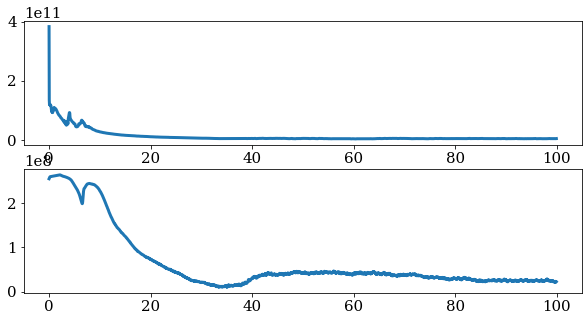

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(tcoor/(24*3600),CL)
plt.subplot(2,1,2)
plt.plot(tcoor/(24*3600),F)

Calculate potential & Landau Free Energy only based on final state (e.g., last month)

In [43]:
bin0_final=np.percentile(a=RCE300.FMSE[-24*30:,:,:],q=50,axis=(0,1,2))

In [44]:
tmp,binm_Vfinal,Vfinal = Landau.Landau_energy(RCE300.FMSE[-24*30:,:,:],dMSE_dt[-24*30:,:,:],bin0,N_bins=30)

In [45]:
Ffinal,binm_Ffinal,tmp = Landau.Landau_energy(RCE300.FMSE,N_bins=30,V_fixed=Vfinal,bin_fixed=binm_Vfinal)

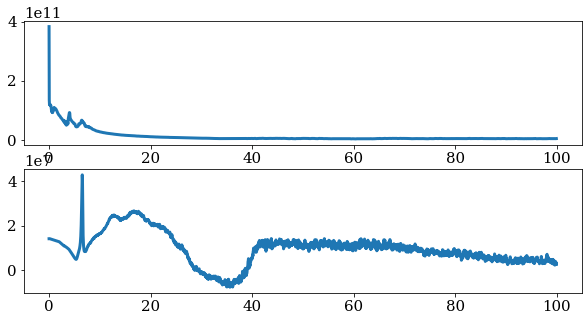

In [47]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(tcoor/(24*3600),CL)
plt.subplot(2,1,2)
plt.plot(tcoor/(24*3600),Ffinal)

Text(0, 0.5, '$\\mathrm{Free\\ Energy\\ \\left[kg^{2}\\ m^{-4}\\ s^{-1}\\right]}$')

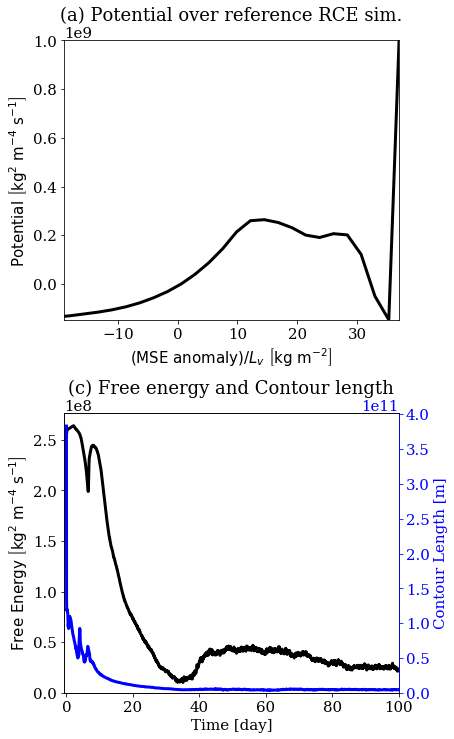

In [103]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(2,1,figsize=(6,12))
plt.subplots_adjust(hspace=0.33)

ax[0].plot((binm-bin0)/2.5e6,V,color='k')
ax[0].set_xlim((-19,37))
ax[0].set_ylim((-1.5e8,1e9))
ax[0].set_title('(a) Potential over reference RCE sim.',pad=20)
ax[0].set_xlabel(r'$\left(\mathrm{MSE\ anomaly}\right)/L_{v}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0].set_ylabel(r'$\mathrm{Potential\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

axbis = ax[1].twinx()
axbis.plot(tcoor/(24*3600),CL,color='b')
axbis.spines['right'].set_color('b')
axbis.tick_params(axis='y', colors='b')
axbis.set_ylim((0,axbis.get_ylim()[1]))
axbis.set_ylabel('Contour Length [m]',color='b')

ax[1].plot(tcoor/(24*3600),F,color='k')
ax[1].set_title('(c) Free energy and Contour length',pad=20)
ax[1].set_xlim((-0.75,100))
ax[1].set_ylim((0,ax[1].get_ylim()[1]))
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel(r'$\mathrm{Free\ Energy\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

In [104]:
# Save figure
path_home = '/users/tbeucler/'
plt.savefig(path_home+'Fig2a',format='pdf')

<Figure size 432x288 with 0 Axes>